##### The development of a hybrid anomaly detection model begins by loading and cleaning the dataset to remove inconsistencies and irrelevant data. Proceed with selecting the most predictive features for anomaly detection. Divide the data into training and testing sets, ensuring that both contain a representative mix of anomalies and normal instances. Apply feature scaling to standardize the range of the data features, which is crucial for many modeling techniques. Fit the hybrid model, which typically integrates multiple anomaly detection methods to leverage their individual strengths. Finally, the model's effectiveness will be evaluated using precision, recall, and the F1-score, and performance will be visually assessed with a confusion matrix. This comprehensive approach ensures that the hybrid model is robust, accurate, and reliable in detecting anomalies across different data scenarios.

In [4]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 88302 to 73828
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id.orig_p                 50000 non-null  int64  
 1   id.resp_p                 50000 non-null  int64  
 2   flow_duration             50000 non-null  float64
 3   fwd_pkts_tot              50000 non-null  int64  
 4   bwd_pkts_tot              50000 non-null  int64  
 5   fwd_data_pkts_tot         50000 non-null  int64  
 6   bwd_data_pkts_tot         50000 non-null  int64  
 7   fwd_pkts_per_sec          50000 non-null  float64
 8   bwd_pkts_per_sec          50000 non-null  float64
 9   flow_pkts_per_sec         50000 non-null  float64
 10  down_up_ratio             50000 non-null  float64
 11  fwd_header_size_tot       50000 non-null  int64  
 12  fwd_header_size_min       50000 non-null  int64  
 13  fwd_header_size_max       50000 non-null  int64  
 14  bw

C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


              precision    recall  f1-score   support

           0       0.51      1.00      0.68      2349
           1       1.00      0.71      0.83      7651

    accuracy                           0.78     10000
   macro avg       0.76      0.85      0.75     10000
weighted avg       0.89      0.78      0.79     10000

Precision: 0.511430437622469
Recall: 1.0
F1 Score: 0.6767502160760588


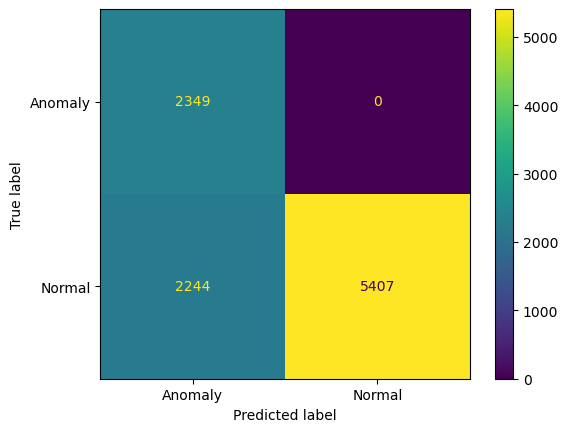

In [5]:
def hybrid_anomaly_detection():
    
    #load dataset
    data1 = pd.read_csv('rt_test.csv')
    
    data = data1.sample(n=50000, random_state=5)
    
    data = data.drop(['proto','service','Attack_type'], axis=1)
    data.dropna(axis=0, inplace=True)

    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
        
    data.info()
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    
    X = data.drop('payload_bytes_per_second', axis=1)  # Assuming 'label' is your target column
    y_cont = data['payload_bytes_per_second']

    # First, binarize `y` based on a chosen threshold.
    y = np.where(y_cont > 1000, 1, 0)  # Define `threshold` based on the dataset
   
    
    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=15)
    X_selected = selector.fit_transform(X, y)
    
    X_selected
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    # Train SVM on the training data
    svm = SVC(kernel='rbf', gamma='scale', class_weight='balanced', random_state=42)
    svm.fit(X_train, y_train)
    svm_predictions_train = svm.predict(X_train)
    svm_predictions_test = svm.predict(X_test)

    # Enhance the dataset with SVM outcomes
    X_train_enhanced = np.hstack((X_train, svm_predictions_train.reshape(-1, 1)))
    X_test_enhanced = np.hstack((X_test, svm_predictions_test.reshape(-1, 1)))

    # Filter only rows SVM detected as normal (label '1')
    normal_indices_train = svm_predictions_train == 1
    X_train_filtered = X_train_enhanced[normal_indices_train]
    y_train_filtered = y_train[normal_indices_train]

    # Train Isolation Forest on filtered normal data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_filtered, y_train_filtered)
    if_predictions = iso_forest.predict(X_test_enhanced)
    if_predictions = np.where(if_predictions == 1, 1, 0)  # Align with binary labels

    # Evaluate the model
    precision = precision_score(y_test, if_predictions, pos_label=0)  # Anomalies labeled as '0'
    recall = recall_score(y_test, if_predictions, pos_label=0)  # Anomalies labeled as '0'
    f1 = f1_score(y_test, if_predictions, pos_label=0)  # Anomalies labeled as '0'

    # Output the evaluation metrics
    
    print(classification_report(y_test, if_predictions))
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, if_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

hybrid_anomaly_detection()
